# Rebuild estimation of feature count from using a grid method

#### Parameters that **have to be** adjustable:

- Size of the grid (i.e. how large is the side of each square)
- Size of the counting square (i.e. how large is the side of each counting square). To consider:
    - Size relative to grid square? Percentage of grid square side or of grid square area?
    - or make its size absolute? --> min > 0 & max = grid square side

### Parameters that **should** adjustable:

- inclusion / exclusion criteria:
    - on which sides of the square / cube is a ROI included / excluded
- position of the counting square:
    - upper left, upper center, upper right
    - middle left, middle center, middle right
    - lower left, lower center, lower right

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import roifile

from typing import Dict, Tuple, List

### Classes:

In [2]:
class CountingSquare:
    
    def __init__(self, size: int, position: str, corners: Dict):
        self.size = size
        self.position = position
        self.all_corner_coords = corners
        self.bounding_box_roi = Polygon([corners['upper_left'], 
                                         corners['upper_right'], 
                                         corners['lower_right'], 
                                         corners['lower_left']])
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    
    def set_in_and_exclusion_sides(self, sides: List[str], passed_in_or_exclusion_sides: str='exclusion') -> None:
        self._assert_valid_input(sides = sides, passed_in_or_exclusion_sides = passed_in_or_exclusion_sides)
        if passed_in_or_exclusion_sides == 'exclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'exclusion')
        elif passed_in_or_exclusion_sides == 'inclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'inclusion')
        for in_or_exclusion_key in ['inclusion', 'exclusion']:
            for attribute_key in ['as_strings', 'as_lines']:
                setattr(self, f'{in_or_exclusion_key}_sides_{attribute_key}', in_and_exclusion_attributes[in_or_exclusion_key][attribute_key])
            
    
    def _assert_valid_input(self, sides: List[str], passed_in_or_exclusion_sides: str) -> None:
        sides_error_message = '"sides" has to be a list of two string elements, which can be any of these: "upper", "right", "lower", "left" - no duplicates!'
        if type(sides) == list:
            if len(sides) != 2:
                raise ValueError(sides_error_message)
            if sides[0] == sides[1]:
                raise ValueError()
            for elem in sides:
                if type(elem) != str:
                    raise TypeError(sides_error_message)
                if elem not in ['upper', 'right', 'lower', 'left']:
                    raise ValueError(sides_error_message)
        else:
            raise TypeError(sides_error_message)
        in_or_exclusion_error_message = '"passed_in_or_exclusion_sides" has to be either "exclusion" or "inclusion".'
        if type(passed_in_or_exclusion_sides) == str:
            if passed_in_or_exclusion_sides not in ['exclusion', 'inclusion']:
                raise ValueError(in_or_exclusion_error_message)
        else:
            raise TypeError(in_or_exclusion_error_message)             
    
           
    def _derive_in_and_exclusion_attributes(self, sides: List[str], in_or_exclusion: str) -> Dict:
        in_and_exclusion_attributes = {'inclusion': {},
                                       'exclusion': {}}
        in_and_exclusion_attributes[in_or_exclusion]['as_strings'] = sides
        in_and_exclusion_attributes[in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in sides]
        remaining_sides = ['upper', 'right', 'lower', 'left']
        for side_string in sides:
            remaining_sides.remove(side_string)
        if in_or_exclusion == 'inclusion':
            remaining_in_or_exclusion = 'exclusion'
        else:
            remaining_in_or_exclusion = 'inclusion'
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_strings'] = remaining_sides
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in remaining_sides]        
        return in_and_exclusion_attributes
    
    
    def _construct_line_shape_from_side_string(self, side_string: str) -> LineString:
        corner_point_keys = list(self.all_corner_coords.keys())
        corners = [key for key in corner_point_keys if side_string in key]
        starting_point_coords = self.all_corner_coords[corners[0]]
        end_point_coords = self.all_corner_coords[corners[1]]
        return LineString([starting_point_coords, end_point_coords])

In [3]:
class ImageTile:
    
    def __init__(self, tiles_row_id: int, tiles_col_id: int, tile: np.ndarray):
        self.row_id = tiles_row_id
        self.col_id = tiles_col_id
        self.image = tile
        self.height, self.width = tile.shape[0:2]
        self.all_corner_coords = self._calculate_all_corner_coords()
        self.bounding_box_roi = self._convert_corner_coords_to_bounding_box_roi()
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    def _convert_corner_coords_to_bounding_box_roi(self):
        coords = self.all_corner_coords
        return Polygon([coords['upper_left'], coords['upper_right'], coords['lower_right'], coords['lower_left']])
    
    def _calculate_all_corner_coords(self) -> Dict:
        upper_left = (self.row_id * self.height, self.col_id * self.width)
        shape = (self.height, self.width)
        all_corner_coords = self._corners_from_upper_left_corner_and_shape(upper_left = upper_left, shape = shape)
        return all_corner_coords
    
    def _corners_from_upper_left_corner_and_shape(self, upper_left: Tuple[int, int], shape: Tuple[int, int]) -> Dict:
        all_corner_coords = {}
        all_corner_coords['upper_left'] = upper_left
        all_corner_coords['upper_right'] = (upper_left[0], upper_left[1] + shape[1])
        all_corner_coords['lower_left'] = (upper_left[0] + shape[0], upper_left[1])
        all_corner_coords['lower_right'] = (upper_left[0] + shape[0], upper_left[1] + shape[1])   
        return all_corner_coords
    
    def create_counting_square(self, size: int, position: str, sides_to_exclude: List[str]):
        self._ensure_counting_square_fits_within_tile(size = size)
        counting_square_upper_left_corner_coords = self._get_upper_left_corner_coords_by_position(size = size, position = position)
        all_corners_counting_square = self._corners_from_upper_left_corner_and_shape(upper_left = counting_square_upper_left_corner_coords,
                                                                                     shape = (size, size))
        self.counting_square = CountingSquare(size = size, position = position, corners = all_corners_counting_square)
        self.counting_square.set_in_and_exclusion_sides(sides = sides_to_exclude)
        
    
    def _ensure_counting_square_fits_within_tile(self, size: int):
        if (size > self.height) or (size > self.width):
            error_message_line_1 = 'The "size" you have chosen for the counting square is too large!\n'
            error_message_line_2 = f'It has to fit within your grid with height = {self.height} and width = {self.width}.\n'
            error_message_line_3 = f'Thus, the max value you could select for "size" is {min(self.height, self.width)}.'
            error_message = error_message_line_1 + error_message_line_2 + error_message_line_3
            raise ValueError(error_message)
        
        
    def _get_upper_left_corner_coords_by_position(self, size: int, position: str) -> Tuple[int, int]:
        upper_row = self.all_corner_coords['upper_left'][0]
        middle_row = upper_row + int(self.height * 0.5) - int(size * 0.5)
        lower_row = self.all_corner_coords['lower_left'][0] - size
        left_col = self.all_corner_coords['upper_left'][1]
        center_col = left_col + int(self.width * 0.5) - int(size * 0.5)
        right_col = self.all_corner_coords['upper_right'][1] - size
        if position == 'upper left':
            return (upper_row, left_col)
        elif position == 'upper center':
            return (upper_row, center_col)
        elif position == 'upper right':
            return (upper_row, right_col)
        elif position == 'middle left':
            return (middle_row, left_col)
        elif position == 'middle center':
            return (middle_row, center_col)
        elif position == 'middle right':
            return (middle_row, right_col)
        elif position == 'lower left':
            return (lower_row, left_col)
        elif position == 'lower center':
            return (lower_row, center_col)
        elif position == 'lower right':
            return (lower_row, right_col)
        else:
            raise ValueError(f'Please double-check the "position" you passed.')

### Functions:

In [4]:
# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
def resize_image_and_create_tiles(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width, image_channels = image.shape # might crash with grayscale images?
    tile_height, tile_width = tile_size
    if (image_height % tile_height != 0) or (image_width % tile_width != 0):
        image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)
        image_height, image_width, image_channels = image.shape
    tiles = image.reshape(image_height // tile_height,
                          tile_height,
                          image_width // tile_width,
                          tile_width, 
                          image_channels)
    tiles = tiles.swapaxes(1,2)    
    return image, tiles


def _resize_image_for_tiles_by_padding_bottom_right(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image.shape[:2]
    pixels_required_for_height = tile_size[0] - image_height % tile_size[0]
    pixels_required_for_width = tile_size[1] - image_width % tile_size[1]
    return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width), (0, 0)))

## Testing:

In [5]:
# Load image and roi
image = imread('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/max_rgb.png')

loaded_roi = roifile.ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/max_rgb.roi')
row_coords = loaded_roi.coordinates()[:, 1]
col_coords = loaded_roi.coordinates()[:, 0]
area_roi = Polygon(np.asarray(list(zip(row_coords, col_coords))))

In [6]:
resized_image, tiles = resize_image_and_create_tiles(image = image, tile_size = (500, 500))

In [7]:
overlapping_tiles = []
for row_id in range(tiles.shape[0]):
    for col_id in range(tiles.shape[1]):
        selected_tile = ImageTile(tiles_row_id = row_id, tiles_col_id = col_id, tile = tiles[row_id, col_id])
        if (selected_tile.bounding_box_roi.overlaps(area_roi)) or (selected_tile.bounding_box_roi.within(area_roi)):
            selected_tile.create_counting_square(size = 250, position = 'middle center', sides_to_exclude = ['right', 'lower'])
            overlapping_tiles.append(selected_tile)


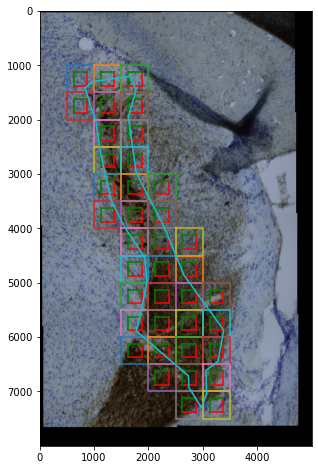

In [8]:
fig = plt.figure(figsize=(15,8))
plt.imshow(resized_image)
for tile in overlapping_tiles:
    plt.plot(tile.bounding_box_x_for_plotting, tile.bounding_box_y_for_plotting)
    for i in range(2):
        plt.plot(tile.counting_square.exclusion_sides_as_lines[i].xy[1], tile.counting_square.exclusion_sides_as_lines[i].xy[0], c='red')
        plt.plot(tile.counting_square.inclusion_sides_as_lines[i].xy[1], tile.counting_square.inclusion_sides_as_lines[i].xy[0], c='green')
plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0])
plt.show()